In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Getting raw dataset from Drive

In [ ]:
!unzip '/content/drive/MyDrive/NSU/Fake_med/archive (2).zip'

### Amount of data per class

In [ ]:
import os

In [ ]:
len(os.listdir('/content/fake-real lung/Fake')), \
len(os.listdir('/content/fake-real lung/Real'))

(3500, 700)

## Copy class folders to a single directory

In [ ]:
import os
os.makedirs('/content/drive/MyDrive/NSU/Fake_med/Dataset1')
!cp -r '/content/fake-real lung/Fake' -d '/content/drive/MyDrive/NSU/Fake_med/Dataset1'
!cp -r '/content/fake-real lung/Real' -d '/content/drive/MyDrive/NSU/Fake_med/Dataset1'


## Split the dataset into the ratio of train: validation: test = 70: 20: 10

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/NSU/Fake_med/Dataset1', output="splitted_data", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 4200 files [00:17, 235.90 files/s]


### Saving splitted dataset to Drive

In [ ]:
!zip -r '/content/splitted_data.zip' '/content/splitted_data'

!cp '/content/splitted_data.zip' -d '/content/drive/MyDrive/NSU/Fake_med'

## Getting splitted data from drive

In [ ]:
!cp '/content/drive/MyDrive/NSU/Fake_med/splitted_data.zip' -d '/content'
!unzip '/content/splitted_data.zip'

## Training

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import all libraries
# Train/Test Libraries

import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

### Data Generators

In [ ]:
data_aug_train = tf.keras.preprocessing.image.ImageDataGenerator(
    height_shift_range = 0.15,
    width_shift_range = 0.15,
    rotation_range = 10,
    shear_range = 0.1,
    fill_mode = 'nearest',
    zoom_range = 0.2)

train_generator = data_aug_train.flow_from_directory(
        '/content/content/splitted_data/train',
        target_size=(224, 224),
        batch_size = 32,
        class_mode ='categorical',
        color_mode = 'rgb',
        classes = ['Fake', 'Real'],
        seed = 2,
        shuffle = True,
        interpolation = 'lanczos'
        )

data_aug_val = tf.keras.preprocessing.image.ImageDataGenerator()

val_generator = data_aug_val.flow_from_directory(
        '/content/content/splitted_data/val',
        target_size =(224, 224),
        batch_size =32,
        class_mode ='categorical',
        color_mode = 'rgb',
        classes= ['Fake', 'Real'],
        seed = 2,
        shuffle = True,
        interpolation = 'lanczos'
        )

data_aug_test = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = data_aug_test.flow_from_directory(
        '/content/content/splitted_data/test',
        target_size = (224, 224),
        batch_size = 421,
        class_mode ='categorical',
        color_mode = 'rgb',
        classes = ['Fake', 'Real'],
        shuffle = False,
        interpolation = 'lanczos'
        )

Found 2939 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


#### Class Indices

In [ ]:
train_generator.class_indices, val_generator.class_indices

({'Fake': 0, 'Real': 1}, {'Fake': 0, 'Real': 1})

### Building and Compiling Model (Transfer Learning)

In [ ]:
# Using pretrained MobileNetV2 model

def MobileNetV2_Model():
  
  baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

  output = baseModel.output
  output = tf.keras.layers.GlobalAveragePooling2D()(output)
  output = tf.keras.layers.Dense(1024, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.15)(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.15)(output)
  output = tf.keras.layers.Dense(2, activation="softmax")(output)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = MobileNetV2_Model()

print("[INFO] compiling model...")
INIT_LR = 0.001
EPOCHS = 100
BATCHSIZE = 64 
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])

print(model.summary())

9406464/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ization)                                                                                         
                                                                                                  
 block_5_expand_relu (ReLU)     (None, 28, 28, 192)  0           ['block_5_expand_BN[0][0]']      
                                                                                                  
 block_5_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_5_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_5_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_5_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_5_d

### Fitting dataset to the Model

In [ ]:
modelPath = '/content/drive/MyDrive/NSU/Fake_med/saved_models/Pretrained MobileNetV2'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.8, patience=10, verbose=1, mode='max',
                                                      min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", mode="max", patience=8)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/MobileNetV2-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='max')

STEP_TRAIN = len(train_generator) 

modelHistory = model.fit(train_generator, steps_per_epoch=STEP_TRAIN, 
                         validation_data= val_generator, epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint, reduceLROnPlat, early])

tf.keras.models.save_model(model, modelPath+'/MobileNetV2-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.3146 - categorical_accuracy: 0.8938 - auc: 0.9502
Epoch 1: val_categorical_accuracy improved from -inf to 0.88690, saving model to /content/drive/MyDrive/NSU/Fake_med/saved_models/Pretrained MobileNetV2/MobileNetV2-best-model.h5
92/92 [==============================] - 90s 855ms/step - loss: 0.3146 - categorical_accuracy: 0.8938 - auc: 0.9502 - val_loss: 0.2609 - val_categorical_accuracy: 0.8869 - val_auc: 0.9734 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.1500 - categorical_accuracy: 0.9449 - auc: 0.9851
Epoch 2: val_categorical_accuracy improved from 0.88690 to 0.96905, saving model to /content/drive/MyDrive/NSU/Fake_med/saved_models/Pretrained MobileNetV2/MobileNetV2-best-model.h5
92/92 [==============================] - 78s 853ms/step - loss: 0.1500 - categorical_accuracy: 0.9449 - auc: 0.9851 - val_loss: 0.1066 - val_categorical_accuracy: 0.9690 - 

### Saving training history

In [ ]:
import pickle
with open('/content/drive/MyDrive/NSU/Fake_med/saved_models/Pretrained MobileNetV2/MobileNetV2_trainHistoryDict', 'wb') as file_pi:
  pickle.dump(modelHistory.history, file_pi)

### Plot history (Accuracy, Loss, Auc)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['categorical_accuracy']
    val_acc = history['val_categorical_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    auc = history['auc']
    val_auc = history['val_auc']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, acc, 'b', label='Training acc',marker = 'p',color='green')
    plt.plot(x,val_acc, 'r', label='Validation acc',marker = 'p',color='red')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right' )
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, label='Training loss',marker = 'p',color='green')
    plt.plot(x, val_loss, label='Validation loss',marker = 'p',color='red')
    plt.title('Training and Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('curve.jpg',dpi=600)
    plt.subplot(1, 3, 3)
    plt.plot(x, auc, 'b', label='Training loss',marker = 'p',color='green')
    plt.plot(x, val_auc, 'r', label='Validation loss',marker = 'p',color='red')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.savefig('curve.jpg',dpi=600)

# plot_history(modelHistory.history)

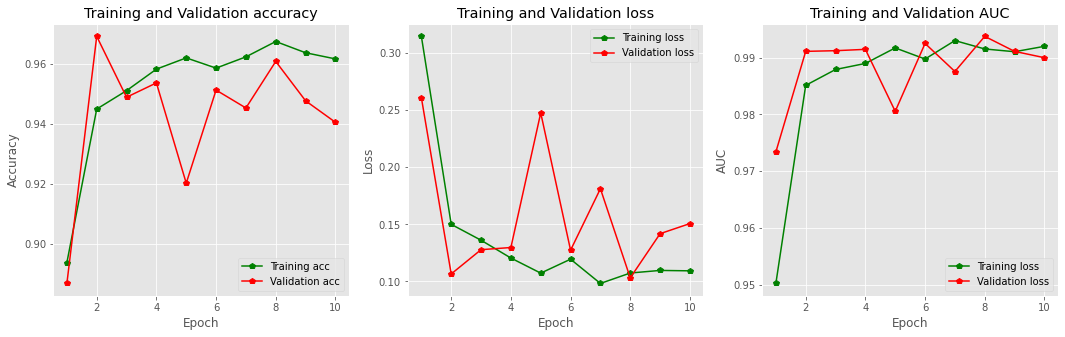

In [ ]:
import pickle
with open('/content/drive/MyDrive/NSU/Fake_med/saved_models/Pretrained MobileNetV2/MobileNetV2_trainHistoryDict', 'rb') as file_pi:
  dct=pickle.load(file_pi)

plot_history(dct)

### Saving model weights and history to Drive

In [ ]:
!cp -r '/content/saved_models' -d '/content/drive/MyDrive/NSU/Fake_med'

cp: cannot stat '/content/saved_models': No such file or directory


## Evaluate model on test data

In [ ]:
!cp -r "/content/drive/MyDrive/NSU/Fake_med/saved_models" -d '/content'   

### Accuracy, Loss and AUC Score

In [ ]:
# Evaluate the Best Saved Model
model = tf.keras.models.load_model('/content/drive/MyDrive/NSU/Fake_med/saved_models/Pretrained MobileNetV2/MobileNetV2-best-model.h5')
loss, accuracy, auc= model.evaluate(test_generator,  verbose=1)
print('Model Accuracy: {:0.2f} | Model Loss: {:0.4f} | Model AUC: {:.02f}'.format(accuracy, loss, auc))

1/1 [==============================] - 9s 9s/step - loss: 0.0986 - categorical_accuracy: 0.9715 - auc: 0.9925
Model Accuracy: 0.97 | Model Loss: 0.0986 | Model AUC: 0.99


### Classification Report and Confusion Matrix

In [ ]:
batch=0
label = []
for x,y in test_generator:
  # cc.append(y)
  if batch==1:
    break
  label.append(y)
  batch+=1
y_true = np.array([np.where(label[0][i] == 1)[0][0] for i in range(len(test_generator.filenames))])
y_true.shape

(421,)

In [ ]:
Y_pred = model.predict_generator(test_generator, 1)
y_pred = np.argmax(Y_pred, axis=1)

<ipython-input-25-57ce4b19589d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, 1)


In [ ]:
classes= ['Fake', 'Real']
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report
              precision    recall  f1-score   support

        Fake       0.97      0.99      0.98       350
        Real       0.97      0.86      0.91        71

    accuracy                           0.97       421
   macro avg       0.97      0.93      0.95       421
weighted avg       0.97      0.97      0.97       421



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,annot_kws={'size':16},xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
        plt.savefig('conf_mat.jpeg',dpi=600)
    else:
        plt.xlabel(stats_text)
        plt.savefig('conf_mat.jpeg',dpi=600)
    
    if title:
        plt.title(title)
        plt.savefig('conf_mat.jpeg',dpi=600)

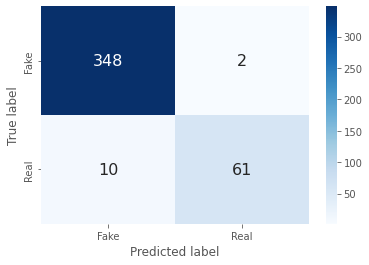

In [ ]:
conf_mat=confusion_matrix(y_true, y_pred)
make_confusion_matrix(conf_mat, figsize=(6,4),percent=False,sum_stats=False,categories=['Fake', 'Real'],cbar=True,cmap='Blues')